# Chapter 4

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as stats
import pandas as pd


ERROR (theano.gpuarray): pygpu was configured but could not be imported or is too old (version 0.7 or higher required)
NoneType: None


(1000,)


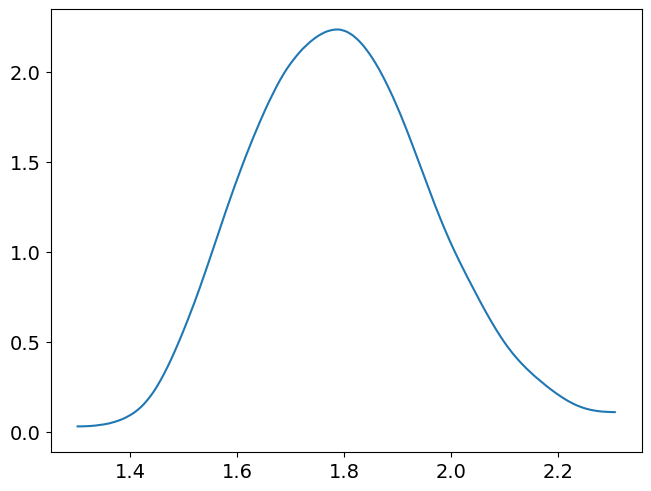

In [18]:
# code 4.2-3
s = np.zeros(1000)
for i in range(1000):
    s[i] = np.prod(np.random.uniform(1, 1.1, 12))

az.plot_kde(s)
plt.show()

(1000,)


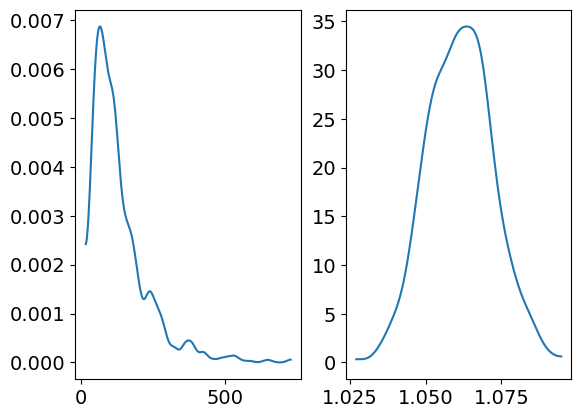

In [25]:
# code 4.4
l = np.random.uniform(1, 2, size=(12, 1000)).prod(0)
s = np.random.uniform(1, 1.01, size=(12, 1000)).prod(0)

fig, ax = plt.subplots(1,2)
az.plot_kde(l, ax=ax[0])
az.plot_kde(s, ax=ax[1])
plt.show()


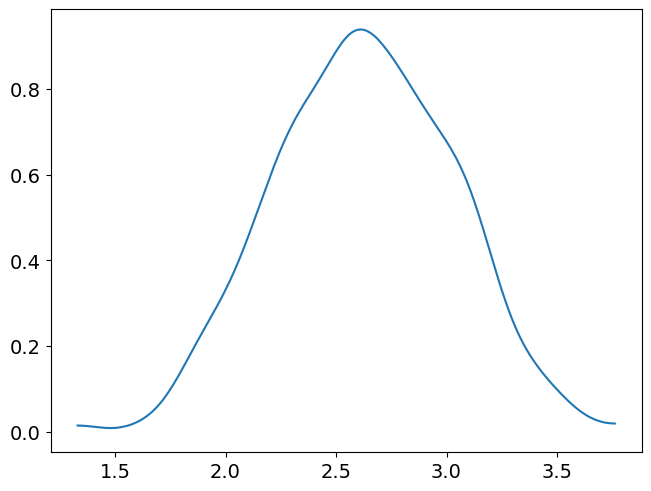

In [29]:
# code 4.5
logbig = np.log(np.random.uniform(1, 1.5, size=(12,1000)).prod(0))

az.plot_kde(logbig)
plt.show()

In [8]:
# code 4.7
d = pd.read_csv("data/Howell1.csv", sep=";", header=0)
d

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062496,21.0,0
542,71.120,8.051258,0.0,1


In [15]:
d2 = d[d.age >= 18]
d2

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
534,162.560,47.031821,27.0,0
537,142.875,34.246196,31.0,0
540,162.560,52.163080,31.0,1
541,156.210,54.062496,21.0,0


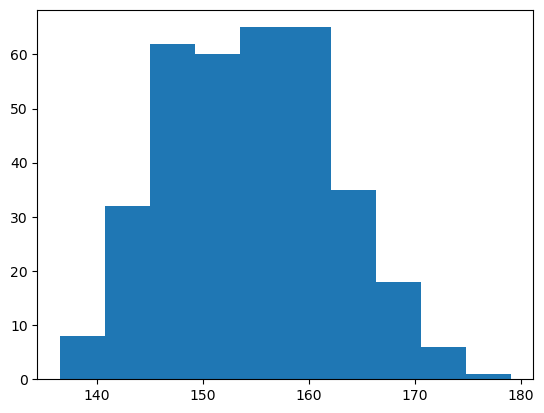

In [28]:
plt.hist(d2.height)
plt.show()

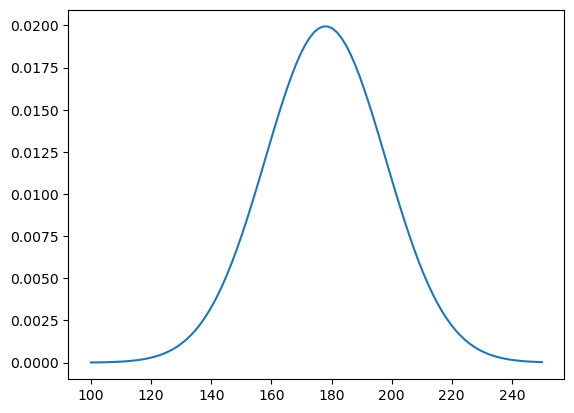

In [33]:
# code 4.12
x = np.linspace(100,250,100)
plt.plot(x, stats.norm.pdf(x, 178, 20))
plt.show()

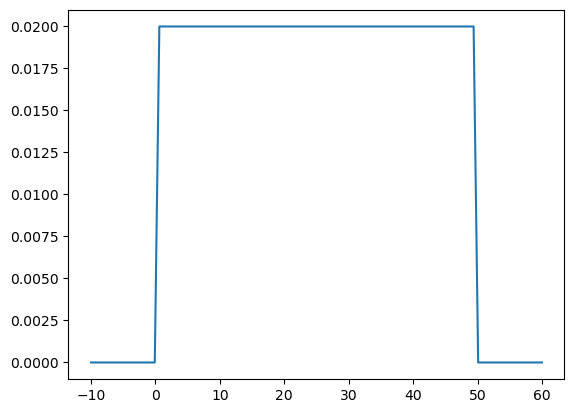

In [34]:
# code 4.13
x = np.linspace(-10, 60, 100)
plt.plot(x, stats.uniform.pdf(x, 0, 50))
plt.show()

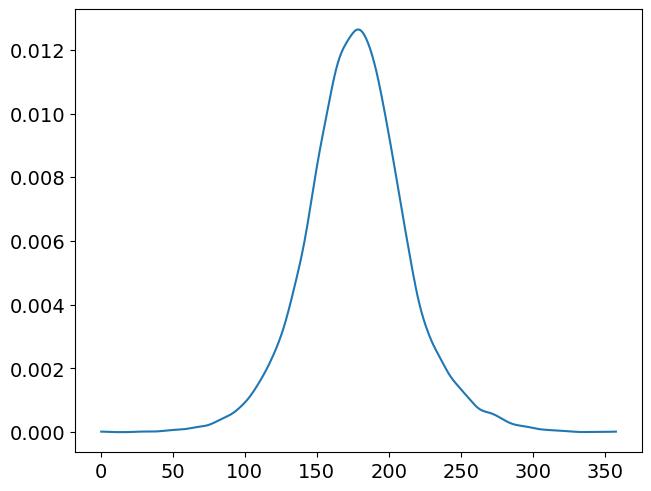

In [43]:
# code 4.14
ns = int(1e4)
sample_mu = stats.norm.rvs(loc=178, scale=20, size=ns)
sample_sigma = stats.uniform.rvs(0, 50, size=ns)
prior_h = stats.norm.rvs(sample_mu, sample_sigma, size=ns)
az.plot_kde(prior_h)
plt.show()

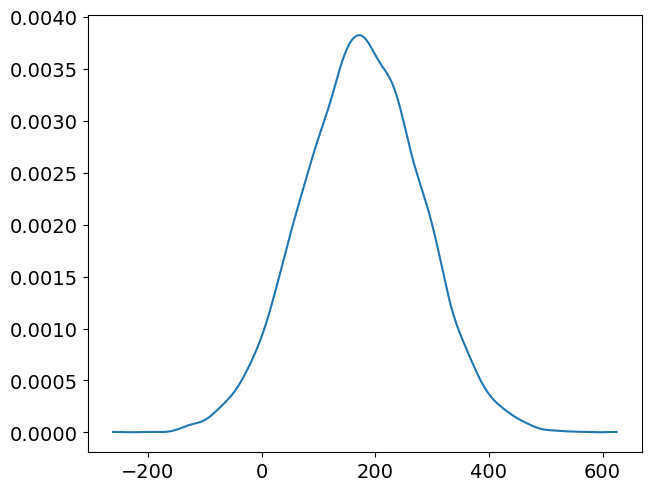

In [44]:
# code 4.15
sample_mu = stats.norm.rvs(loc=178, scale=100, size=ns)
prior_h = stats.norm.rvs(sample_mu, sample_sigma, size=ns)
az.plot_kde(prior_h)
plt.show()

In [46]:
# code 4.16
post = np.mgrid[150:160:0.05, 7:9:0.05].reshape(2, -1).T

likelihood = [
    sum(stats.norm.logpdf(d2.height, loc=post[:, 0][i], scale=post[:, 1][i]))
    for i in range(len(post))
]

post_prod = (
    likelihood
    + stats.norm.logpdf(post[:, 0], loc=178, scale=20)
    + stats.uniform.logpdf(post[:, 1], loc=0, scale=50)
)
post_prob = np.exp(post_prod - max(post_prod))

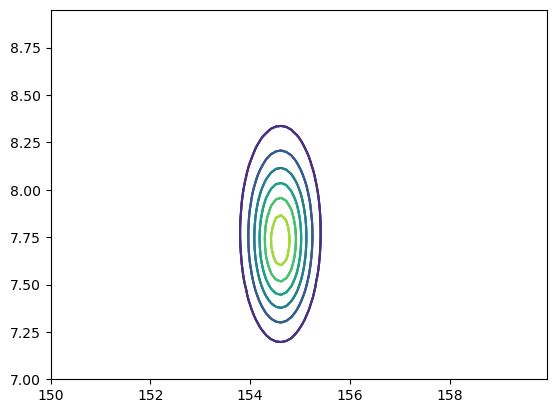

In [50]:
# code 4.17
from scipy.interpolate import griddata
xi = np.linspace(post[:, 0].min(), post[:, 0].max(), 100)
yi = np.linspace(post[:, 1].min(), post[:, 1].max(), 100)
zi = griddata((post[:, 0], post[:, 1]), post_prob, (xi[None, :], yi[:, None]))

plt.contour(xi, yi, zi);
plt.show()

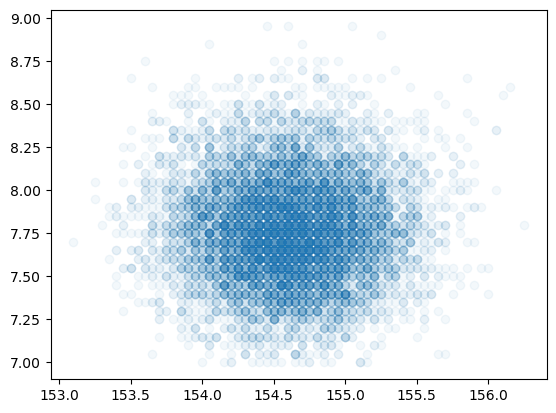

In [66]:
# code 4.19
sample_rows = np.random.choice(np.arange(len(post)), size=ns, replace=True, p=post_prob / post_prob.sum())
sample_mu = post[:,0][sample_rows]
sample_sigma = post[:,1][sample_rows]

plt.plot(sample_mu, sample_sigma, "o", alpha=0.05)
plt.show()

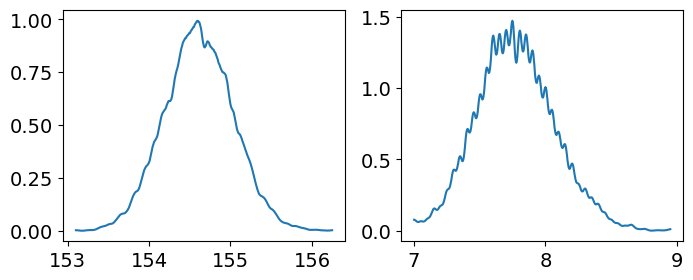

In [70]:
# code 4.21
_, ax = plt.subplots(1,2, figsize=(8,3))
az.plot_kde(sample_mu, ax=ax[0])
az.plot_kde(sample_sigma, ax=ax[1])

plt.show()

In [72]:
# code 4.22
az.hdi(sample_mu), az.hdi(sample_sigma)

(array([153.8 , 155.35]), array([7.25, 8.35]))

In [77]:
# code 4.23

d3 = np.random.choice(d2.height, 20)
post2 = np.mgrid[150:170:0.1, 4:20:0.1].reshape(2, -1).T

likelihood2 = [
    sum(stats.norm.logpdf(d3, loc=post2[:, 0][i], scale=post2[:, 1][i])) for i in range(len(post2))
]

post_prod2 = (
    likelihood2
    + stats.norm.logpdf(post2[:, 0], loc=178, scale=20)
    + stats.uniform.logpdf(post2[:, 1], loc=0, scale=50)
)

post_prob2 = np.exp(post_prod2 - max(post_prod2))

sample_rows2 = np.random.choice(
    np.arange(len(post2)), size=10000, replace=True, p=(post_prob2 / post_prob2.sum())
)
sample_mu2 = post2[:, 0][sample_rows2]
sample_sigma2 = post2[:, 1][sample_rows2]

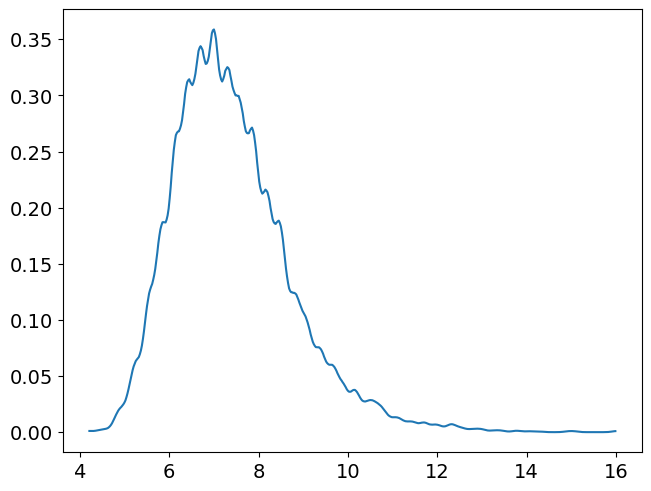

In [95]:
az.plot_kde(sample_sigma2)
plt.show()

In [2]:
# code 4.26 +
d = pd.read_csv("data/Howell1.csv", sep=";", header=0)
d2 = d[d.age>=18]

with pm.Model() as m4_1:
    mu = pm.Normal("mu", mu=178, sd=20)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)
    
with m4_1:
    trace_4_1 = pm.sample(1000, tune=1000)

<ipython-input-2-886ab6c6088a>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_4_1 = pm.sample(1000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


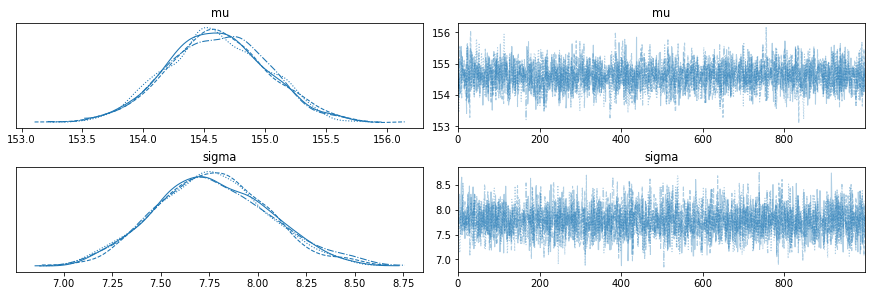

In [11]:
#pm.traceplot(trace_4_1)
with m4_1:
    az.plot_trace(trace_4_1);

In [18]:
az.summary(trace_4_1, var_names=["mu", "sigma"], round_to=2, kind="stats")

/home/sam/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%
mu,154.61,0.41,153.85,155.39
sigma,7.77,0.30,7.19,8.31


In [19]:
# code 4.31
d = pd.read_csv("data/Howell1.csv", sep=";", header=0)
d2 = d[d.age>=18]

with pm.Model() as m4_2:
    mu = pm.Normal("mu", mu=178, sd=0.1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)
    
with m4_2:
    trace_4_2 = pm.sample(1000, tune=1000)

<ipython-input-19-dcf059a5e281>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_4_2 = pm.sample(1000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


/home/sam/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%
mu,177.86,0.10,177.68,178.04
sigma,24.59,0.92,22.82,26.28


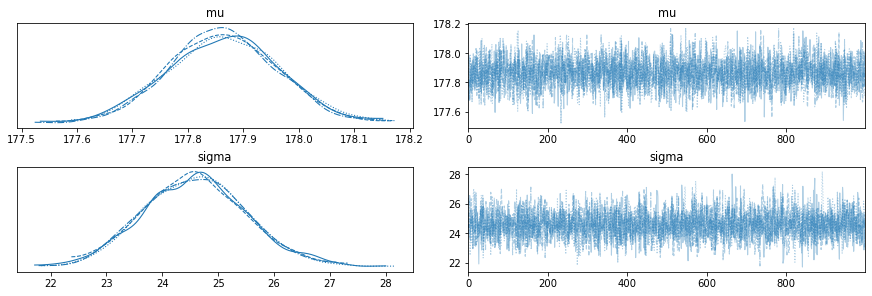

In [22]:
with m4_2:
    az.plot_trace(trace_4_2)
az.summary(trace_4_2, var_names=["mu", "sigma"], round_to=2, kind="stats")

In [26]:
# code 4.32
trace_df = pm.trace_to_dataframe(trace_4_1)
trace_df.cov()

,mu,sigma
mu,0.171113,0.002128
sigma,0.002128,0.087261


In [27]:
np.diag(trace_df.cov()) # diagonal gives us the variances

array([0.17111311, 0.08726111])

In [28]:
trace_df.corr() # correlations

,mu,sigma
mu,1.000000,0.017414
sigma,0.017414,1.000000


In [29]:
# code 4.34
trace_df.head()

,mu,sigma
0,154.632446,7.961289
1,154.939041,7.662434
2,154.248764,7.972524
3,155.145355,7.716280
4,154.276016,7.818957


In [30]:
print("10 Sigma samples: ", trace_4_1["sigma"][:10])
print("10 Mu samples: ", trace_4_1["mu"][:10])

10 Sigma samples:  [7.9612894 7.6624336 7.972524  7.7162795 7.818957  7.8100777 7.510009
 8.127805  8.498109  8.646414 ]
10 Mu samples:  [154.63245 154.93904 154.24876 155.14536 154.27602 154.02788 155.05882
 154.43272 155.54045 155.09511]


In [31]:
# code 4.36
stats.multivariate_normal.rvs(mean=trace_df.mean(), cov=trace_df.cov(), size=10)

array([[154.93206719,   7.92969857],
       [154.46246385,   8.12607054],
       [154.23462908,   7.62413874],
       [155.14613664,   7.94901643],
       [154.56240393,   7.82553119],
       [155.16514822,   7.64136103],
       [154.47120835,   7.98807138],
       [154.39184268,   7.49077795],
       [154.46257333,   7.77201244],
       [154.26808254,   7.74955319]])

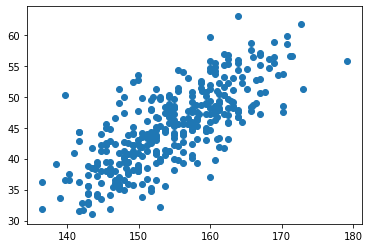

In [33]:
# code 4.37
plt.scatter(d2["height"], d2["weight"]);

In [47]:
# code 4.38
N = 100
a = np.random.normal(178, 20, size=N)
b = np.random.normal(0, 10, size=N)

[ -6.9252241  -19.29442497  -2.93085063  -2.03201576  14.20083927
  10.03913338   0.38242155  10.16158843   8.07530788   5.24738838
   1.66945168  -5.0322958    0.52845695  -6.92726123  -6.11451075
   2.31741914  -4.59303842 -16.12095175   0.86493082 -12.02790356
  -6.27533887 -10.34873346  -6.52475766   2.53850943  -9.05020147
  15.85541212  12.98407616  26.96427565  -0.92115085  12.85273175
  20.1153465  -15.60374839   3.96798171  10.63237143  -8.47092092
 -22.35055231  -0.5263859    8.15303738   4.17295652   1.30285517
  -6.85632763 -14.01509904 -20.71551164   8.71551055   6.09684567
   3.50129039 -19.04211369 -13.98254426  -4.88924784   5.37010367
  -3.35197572 -14.32042945 -14.65566714   1.57679116  11.78970081
  -7.50381299  -0.14728734   2.22474486  -5.18151302  -0.93532124
  11.44476325   3.84140511  -4.15603553  -4.31541768  -2.52849104
 -21.4972969    9.69765138 -14.93534955  -5.32114437   0.91619992
 -13.50101697  11.35967107 -10.22519197 -11.34914457  -0.25827585
   4.25294

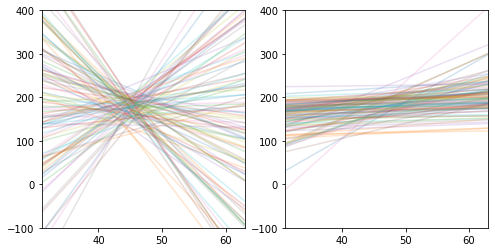

In [72]:
# code 4.39
lb = np.random.lognormal(0,1, size=N)
x = np.linspace(d2["weight"].min(), d2["weight"].max(), 1000)
xbar = d2["weight"].mean()

fig, ax = plt.subplots(1,2,figsize=(8,4))
for i in range(N):
    ax[0].plot(x, a[i] + b[i]*(x-xbar), alpha=0.2)
    ax[1].plot(x, a[i] + lb[i]*(x-xbar), alpha=0.2)
    
ax[0].set_xlim(d2["weight"].min(), d2["weight"].max())
ax[1].set_xlim(d2["weight"].min(), d2["weight"].max())
ax[0].set_ylim([-100, 400])
ax[1].set_ylim([-100, 400]);

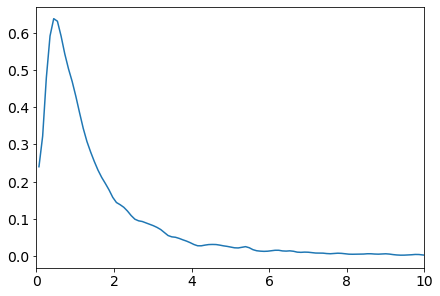

In [86]:
# code 4.40
b = np.random.lognormal(0, 1, 10000)
az.plot_kde(b)
plt.xlim([0,10])
plt.show()

In [2]:
# code 4.42
d = pd.read_csv("data/Howell1.csv", sep=";", header=0)
d2 = d[d.age>=18]
xbar = d2["weight"].mean()

with pm.Model() as m4_3:
    a = pm.Normal("a", mu=178, sd=20)
    b = pm.Lognormal("b", mu=0, sd=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = a + b * (d2.weight - xbar)
    height = pm.Normal("height", mu=mu, sd=sigma, observed = d2.height)
    
    trace_4_3 = pm.sample(1000, tune=1000)
    

<ipython-input-2-c411f38b7e87>:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_4_3 = pm.sample(1000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [3]:
az.summary(trace_4_3, var_names=["a", "b", "sigma"], round_to=2, kind="stats")

/home/sam/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%
a,154.61,0.27,154.11,155.13
b,0.90,0.04,0.82,0.98
sigma,5.10,0.20,4.73,5.46


In [4]:
trace_df = pm.trace_to_dataframe(trace_4_3)
trace_df.cov()

,a,b,sigma
a,0.075313,0.000147,-0.001331
b,0.000147,0.001809,0.000159
sigma,-0.001331,0.000159,0.038299


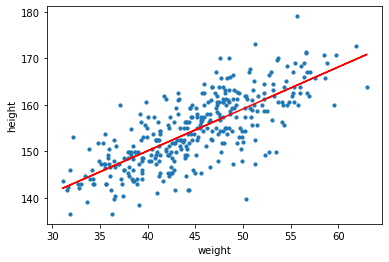

In [5]:
am = trace_4_3["a"].mean()
bm = trace_4_3["b"].mean()
x = np.linspace(d2.weight.min(), d2.weight.max(), 1000)

plt.scatter(d2.weight, d2.height, 10)
plt.plot(d2.weight, am + bm*(d2.weight - d2.weight.mean()), 'r')
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

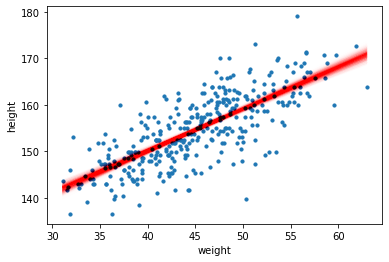

In [6]:
# code 4.49
plt.scatter(d2.weight, d2.height, 10)
for i in range(1000):
    plt.plot(d2.weight, trace_4_3["a"][i] + trace_4_3["b"][i] * (d2.weight - d2.weight.mean()), 'r', alpha=0.002)
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

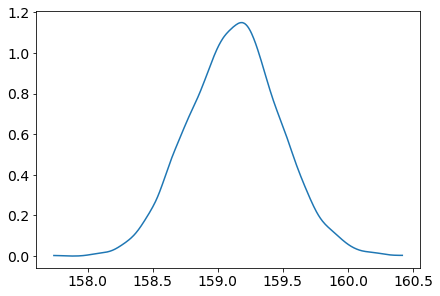

In [8]:
# code 4.50-51
mu_at_50 = trace_4_3["a"] + trace_4_3["b"] * (50 - xbar)
az.plot_kde(mu_at_50);

In [11]:
# code 4.52
az.hdi(mu_at_50, hdi_prob=0.89)

array([158.57973, 159.68419], dtype=float32)

In [28]:
trace_4_3_cut["a"].shape

(200,)

In [29]:
# code 4.53
weight_interval = np.arange(25, 71, 1)
trace_4_3_cut = trace_4_3[::20]
mu_at_w = np.zeros((len(weight_interval), len(trace_4_3_cut) * trace_4_3.nchains))
for i, w in enumerate(weight_interval):
    mu_at_w[i,:] = trace_4_3_cut["a"] + trace_4_3_cut["b"] * (w - xbar)

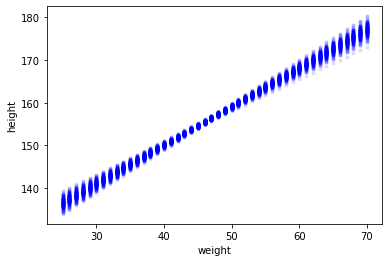

In [38]:
# code 4.55
plt.plot(weight_interval, mu_at_w, "b.", alpha=0.1);
plt.xlabel("weight")
plt.ylabel("height");

In [43]:
mu_means = mu_at_w.mean(1)
mu_hdi = az.hdi(mu_at_w)
print(mu_hdi.shape)

(200, 2)


/home/sam/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


(30.0, 65.0)

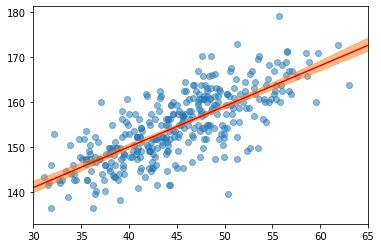

In [59]:
# code 4.56
plt.scatter(d2.weight, d2.height,alpha=0.5)
az.plot_hdi(weight_interval, mu_at_w.T, hdi_prob=0.89)
plt.plot(weight_interval, mu_means, 'r')
plt.xlim([30, 65])

In [88]:
# code 4.58-61
h_pred = pm.sample_posterior_predictive(trace_4_3, 2000, m4_3)
h_pred_hdi = az.hdi(h_pred["height"])

/home/sam/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/sam/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


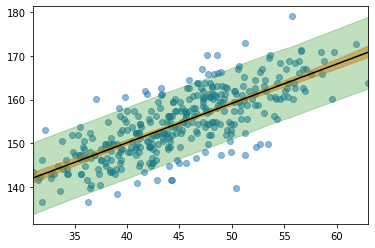

In [90]:
plt.scatter(d2.weight, d2.height,alpha=0.5)
az.plot_hdi(weight_interval, mu_at_w.T, hdi_prob=0.89)
az.plot_hdi(d2.weight, h_pred["height"], hdi_prob=0.89, fill_kwargs={"alpha": 0.25, "color": 'g'})
plt.plot(weight_interval, mu_means, 'k')
plt.xlim([d2.weight.min(), d2.weight.max()]);

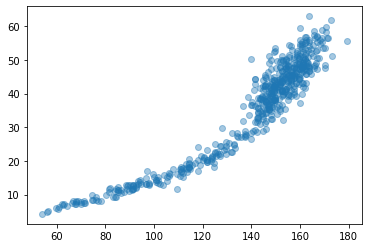

In [94]:
# code 4.64
d = pd.read_csv("data/Howell1.csv", sep=";", header=0)
plt.scatter(d.height, d.weight, alpha=0.4);

In [126]:
# code 4.65
ws = (d.weight - d.weight.mean()) / d.weight.std()
ws2 = ws**2

with pm.Model() as m4_4:
    a = pm.Normal("a", mu=178, sd=20)
    b1 = pm.Lognormal("b1", mu=0, sd=1)
    b2 = pm.Normal("b2", mu=0, sd=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = pm.Deterministic("mu", a + b1*ws + b2*ws2)
    height = pm.Normal("height", mu=mu, sd=sigma, observed = d.height)
    
    trace_4_4 = pm.sample(1000, tune=1000)

<ipython-input-126-2525f56ffb25>:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_4_4 = pm.sample(1000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b2, b1, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


/home/sam/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


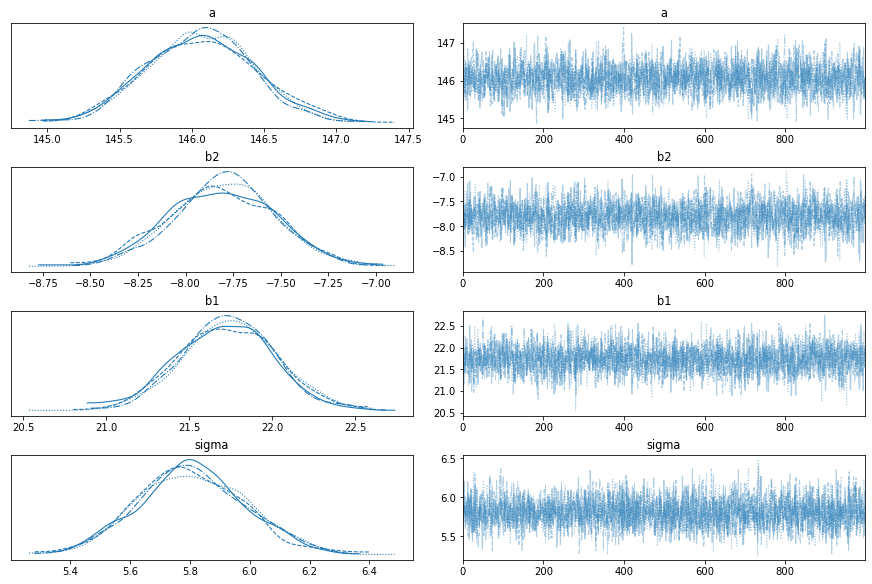

In [128]:
varnames = ["~mu"]
az.plot_trace(trace_4_4, varnames);

In [129]:
az.summary(trace_4_4, var_names=["a", "b1", "b2", "sigma"], round_to=2, kind="stats")

/home/sam/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%
a,146.06,0.37,145.37,146.76
b1,21.73,0.29,21.18,22.27
b2,-7.80,0.28,-8.31,-7.27
sigma,5.81,0.18,5.48,6.15


/home/sam/miniconda3/envs/bayes/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/home/sam/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/sam/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


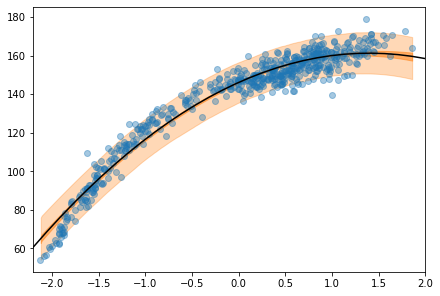

In [157]:
# 4.67-68
# mean of mu
weight_seq = np.linspace(-2.2, 2, 30)
trace_4_4_cut = trace_4_4[::20]
mu_at_w = np.zeros((len(weight_seq), len(trace_4_4_cut) * trace_4_4.nchains))
for i, w in enumerate(weight_seq):
    mu_at_w[i,:] = trace_4_4_cut["a"] + trace_4_4_cut["b1"] * w + trace_4_4_cut["b2"] * w**2   
    
mu_means = mu_at_w.mean(1)

# mu samples -> hdi
mu_pred = trace_4_4["mu"]
height_pred = pm.sample_posterior_predictive(trace_4_4, 200, m4_4)
ax = az.plot_hdi(ws, mu_pred)
az.plot_hdi(ws, height_pred["height"], ax=ax, fill_kwargs={"alpha": 0.3})
plt.plot(weight_seq, mu_means, 'k')
plt.scatter(ws, d.height, alpha=0.4)
plt.xlim([-2.2, 2]);

In [28]:
# 4.72
d = pd.read_csv("data/cherry_blossoms.csv", sep=";", header=0)
d
#az.summary(d.dropna().to_dict(orient="list"), kind="stats")

,year,doy,temp,temp_upper,temp_lower
0,801,NaN,NaN,NaN,NaN
1,802,NaN,NaN,NaN,NaN
2,803,NaN,NaN,NaN,NaN
3,804,NaN,NaN,NaN,NaN
4,805,NaN,NaN,NaN,NaN
...,...,...,...,...,...
1210,2011,99.0,NaN,NaN,NaN
1211,2012,101.0,NaN,NaN,NaN
1212,2013,93.0,NaN,NaN,NaN
1213,2014,94.0,NaN,NaN,NaN


In [59]:
# code 4.73
num_knots = 15
d2 = d.dropna(subset=["doy"])
knot_list = np.quantile(d2["year"], np.linspace(0, 1, num_knots))
print(knot_list)

[ 812. 1036. 1174. 1269. 1377. 1454. 1518. 1583. 1650. 1714. 1774. 1833.
 1893. 1956. 2015.]


In [60]:
from patsy import dmatrix

B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True) - 1",
    {"year": d2.year.values, "knots": knot_list[1:-1]},
)
# to see data: np.asarray(B)
np.asarray(B).shape

(827, 17)

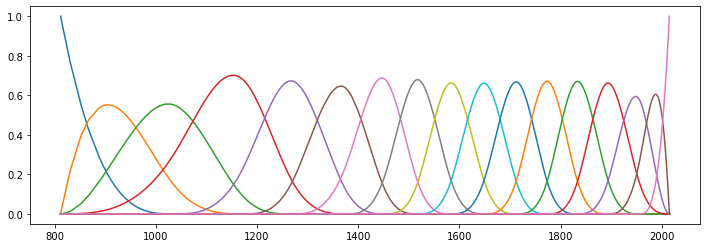

In [61]:
# code 4.75
fig, ax = plt.subplots(figsize=(12,4))
for i in range(17):
    ax.plot(d2.year, (B[:,i]))

In [62]:
# code 4.76
with pm.Model() as m4_7:
    a = pm.Normal("a", 100, 10)
    w = pm.Normal("w", mu=0, sd=10, shape=B.shape[1])
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))
    # mu = pm.Deterministic("mu", a + pm.math.dot(B.base, w.T))
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu, sigma, observed=d2.doy)
    trace_m4_7 = pm.sample(1000)

<ipython-input-62-7188480e9ecb>:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_m4_7 = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, w, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
There were 123 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6830340714362987, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


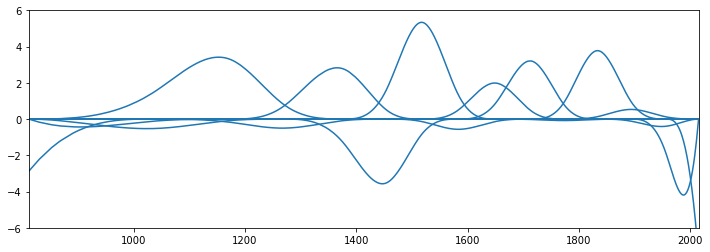

In [63]:
# code 4.77
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
wp = trace_m4_7[w].mean(0)
for i in range(17):
    ax.plot(d2.year, (wp[i] * B[:, i]), color="C0")
ax.set_xlim(812, 2015)
ax.set_ylim(-6, 6);

/home/sam/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


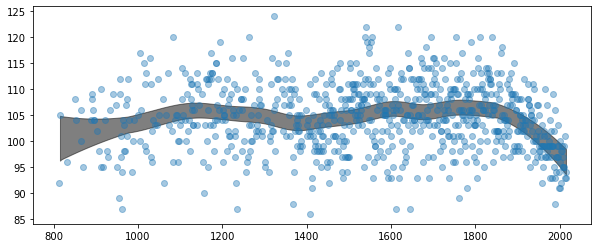

In [64]:
# code 4.78
fig, ax = plt.subplots(figsize=(10,4))
az.plot_hdi(d2.year, trace_m4_7["mu"], color="k")
ax.plot(d2.year, d2.doy, "o", alpha=0.4)
plt.show()

---

# Practice

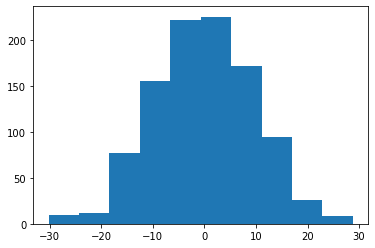

In [69]:
# 4M1.
mu = np.random.normal(0, 10, size=1000)
sigma = np.random.exponential(1, size=1000)
y = np.random.normal(mu, sigma)
plt.hist(y);

In [72]:
# 4M2.
with pm.Model() as m4M2:
    mu = pm.Normal("mu", 0, 10)
    sigma = pm.Exponential("sigma", 1)
    y = pm.Normal("y", mu, sigma)

4M3.

$\large y \sim Normal(\mu, \sigma)$

$\large mu_i = \alpha + \beta x_i$

$\large \alpha \sim Normal(0, 1)$

$\large \beta \sim Uniform(0, 1)$

$\large \sigma \sim Exp(1)$

4M4.

$\large h \sim Normal(\mu, \sigma)$

$\large mu_i = \alpha + \beta x_i$

$\large \alpha \sim Normal(1.5, 0.1)$

$\large \beta \sim LogNormal(0, 1)$ (positive only)

$\large \sigma \sim Uniform(0, 20)$

4M5.
Accounted for by LogNormal

4M6. 

$\large \sigma \sim Uniform(0, 8)$ as variance $= \sigma^2$

In [5]:
# 4H1.
d = pd.read_csv("data/Howell1.csv", sep=";", header=0)

with pm.Model() as m4H1:
    
    a = pm.Normal("a", mu=150, sd=30)
    b = pm.Lognormal("b", mu=0, sd=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = pm.Deterministic("mu", a + b*d.weight)
    height = pm.Normal("height", mu=mu, sd=sigma, observed = d.height)

    trace_4H1 = pm.sample(1000, tune=2000)

<ipython-input-5-f1af2beeeb26>:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_4H1 = pm.sample(1000, tune=2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.8862058762893202, but should be close to 0.8. Try to increase the number of tuning steps.


In [8]:
individuals = np.linspace(1, 5, 5)
weights = np.array([46.95, 43.72, 64.78, 32.59, 54.63])

pred_height = trace_4H1["a"].mean() + trace_4H1["b"].mean()*weights

int_lo = np.zeros(5)
int_hi = np.zeros(5)

for i in range(len(weights)):
    p = trace_4H1["a"] + trace_4H1["b"]*weights[i]
    hdi = az.hdi(p, prob=0.89)
    int_lo[i] = hdi[0]
    int_hi[i] = hdi[1]

data_dict = {
    "Individual": individuals,
    "Weight": weights,
    "Expected height": pred_height,
    "Low_interval": int_lo,
    "Upper_interval": int_hi,
}

pd.DataFrame(data=data_dict)

,Individual,Weight,Expected height,Low_interval,Upper_interval
0,1.0,46.95,158.263723,157.311539,159.232178
1,2.0,43.72,152.571519,151.681351,153.423279
2,3.0,64.78,189.685394,188.003143,191.425934
3,4.0,32.59,132.957206,132.189117,133.709991
4,5.0,54.63,171.798128,170.537506,173.024261


In [11]:
# 4H2.
d2 = d[d.age < 18]
print(d2.shape)

(192, 4)


In [12]:
# 4H2a.

with pm.Model() as m4H2a:
    
    a = pm.Normal("a", mu=150, sd=30)
    b = pm.Lognormal("b", mu=0, sd=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = pm.Deterministic("mu", a + b*d2.weight)
    height = pm.Normal("height", mu=mu, sd=sigma, observed = d2.height)

    trace_4H2a = pm.sample(1000, tune=2000)

<ipython-input-12-218b1e32e374>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_4H2a = pm.sample(1000, tune=2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 3 seconds.


/home/sam/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


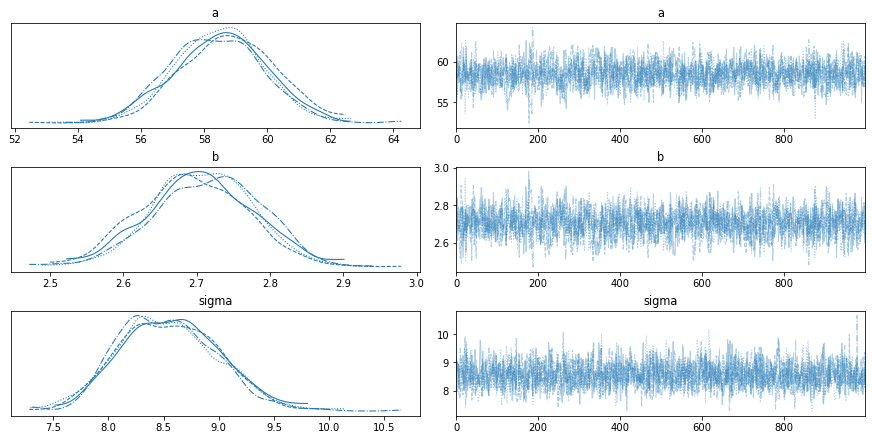

In [15]:
varnames = ["~mu"]
az.plot_trace(trace_4H2a, varnames);

In [17]:
az.summary(trace_4H2a, varnames)

/home/sam/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,58.546,1.449,55.882,61.238,0.036,0.026,1595.0,1778.0,1.01
b,2.707,0.071,2.580,2.842,0.002,0.001,1580.0,1734.0,1.01
sigma,8.552,0.443,7.754,9.357,0.010,0.007,1925.0,1898.0,1.00


In [22]:
print("Answer:", round(trace_4H2a["b"].mean() * 10,2), "cm")

Answer: 27.07 cm


/home/sam/miniconda3/envs/bayes/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/home/sam/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/sam/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


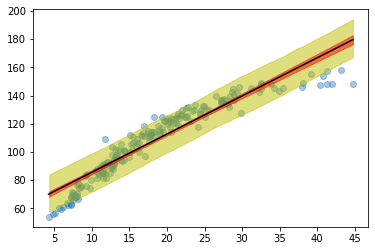

In [46]:
#4H2b.
height_pred = pm.sample_posterior_predictive(trace_4H2a, 200, m4H2a)
x = np.linspace(d2.weight.min(), d2.weight.max(), 100)

plt.scatter(d2.weight, d2.height, alpha=0.4)
plt.plot(x, trace_4H2a["a"].mean() + trace_4H2a["b"].mean()*x, color="k")
az.plot_hdi(d2.weight, height_pred["height"], color="y", hdi_prob=0.89)
az.plot_hdi(d2.weight, trace_4H2a["mu"], color="r", hdi_prob=0.89);

In [ ]:
# 4H2c
# There appears to be a clear nonlinearity in the dataset that is currently not captured by the model.

In [15]:
# 4H3
d = pd.read_csv("data/Howell1.csv", sep=";", header=0)

logw = np.log(d.weight)

# Define and estimate model
with pm.Model() as m4H3:
    
    a = pm.Normal("a", mu=178, sd=20)
    b = pm.Lognormal("b", mu=0, sd=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = pm.Deterministic("mu", a + b*logw)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d.height)
    
    trace_4H3 = pm.sample(1000, tune=1000)
    

<ipython-input-15-79f48f5d944f>:15: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_4H3 = pm.sample(1000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [16]:
varnames = ["~mu"]
az.summary(trace_4H3, varnames)

/home/sam/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-22.913,1.382,-25.582,-20.419,0.040,0.028,1188.0,1256.0,1.0
b,46.830,0.395,46.093,47.577,0.011,0.008,1224.0,1276.0,1.0
sigma,5.159,0.158,4.861,5.454,0.004,0.002,1996.0,1796.0,1.0


/home/sam/miniconda3/envs/bayes/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/home/sam/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/sam/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


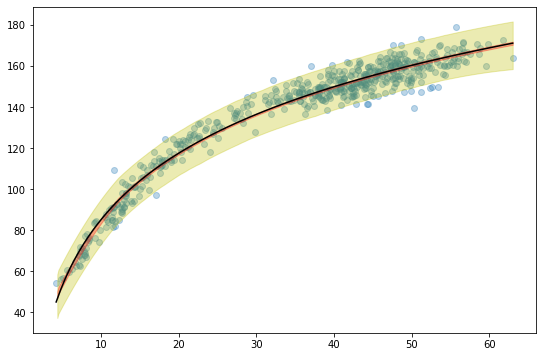

In [35]:
# Plot: 
# predicted mean height as function of weight
# 97% interval for the mean
# 97% interval for predicted height
fig, ax = plt.subplots(figsize=(9,6))

height_pred = pm.sample_posterior_predictive(trace_4H3, 200, m4H3)
x = np.linspace(d.weight.min(), d.weight.max(), 100)

plt.scatter(d.weight, d.height, alpha=0.3)
plt.plot(x, trace_4H3["a"].mean() + trace_4H3["b"].mean()*np.log(x), color="k")
az.plot_hdi(d.weight, height_pred["height"], color="y", hdi_prob=0.97, fill_kwargs={"alpha": 0.3})
az.plot_hdi(d.weight, trace_4H3["mu"], color="r", fill_kwargs={"alpha": 0.3}, hdi_prob=0.97);

In [40]:
# 4H4
ws = (d.weight - d.weight.mean()) / d.weight.std()
ws2 = ws**2

with pm.Model() as m4_4:
    a = pm.Normal("a", mu=178, sd=20)
    b1 = pm.Lognormal("b1", mu=0, sd=1)
    b2 = pm.Normal("b2", mu=0, sd=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = pm.Deterministic("mu", a + b1*ws + b2*ws2)
    height = pm.Normal("height", mu=mu, sd=sigma, observed = d.height)
    
    pp = pm.sample_prior_predictive(samples=1000)
    
    trace_4_4 = pm.sample(1000, tune=1000)

<ipython-input-40-716d9c59e313>:15: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_4_4 = pm.sample(1000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b2, b1, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


/home/sam/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


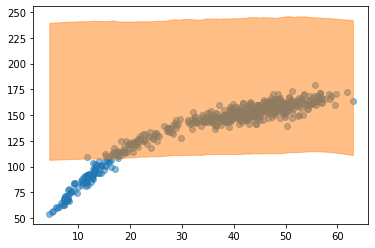

In [44]:
plt.scatter(d.weight, d.height, alpha=0.5)
az.plot_hdi(d.weight, pp["height"]);

In [73]:
with pm.Model() as m4_4:
    a = pm.Normal("a", mu=135, sd=20) # decrease mu
    b1 = pm.Lognormal("b1", mu=2.5, sd=1) # stronger positive relationship
    b2 = pm.Lognormal("b2", mu=0, sd=0.05) # narrower
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = pm.Deterministic("mu", a + b1*ws + b2*ws2)
    height = pm.Normal("height", mu=mu, sd=sigma, observed = d.height)
    
    pp = pm.sample_prior_predictive(samples=1000)
    
    trace_4_4 = pm.sample(1000, tune=1000)

<ipython-input-73-68487460dfcf>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_4_4 = pm.sample(1000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b2, b1, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


/home/sam/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


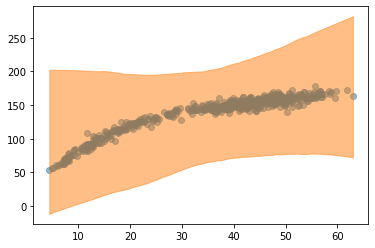

In [74]:
plt.scatter(d.weight, d.height, alpha=0.5)
az.plot_hdi(d.weight, pp["height"]);